<h1>Long Report</h1>

Let's start by a few imports :

In [3]:
from sales_forecast import forecast_model
from numpy import linspace
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy

plt.style.use('ggplot')
#plt.style.use('dark_background')

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We create the model, who imports the data, then sets some graphics parameters :

In [4]:
model = forecast_model()

#print(model.test_data.head())
#print(model.train_data.head())
#print(model.stores.head())
#print(model.features.head())
#print(len(model.train_data['ts_id'].unique()))

#sns.set_style("ggplot")

<h2>Exploratory Data Analysis</h2>

Let's estimate the size of the data :

In [5]:
print(f"Number of stores : {len(list(model.stores['Store'].value_counts()))}")
print(f"Number of SKU : {len(list(model.stores['SKU'].value_counts()))}")
print(f"Number of time series : {len(list(model.train_data['ts_id'].value_counts()))}")

Number of stores : 267
Number of SKU : 18
Number of time series : 1891


Let's have a look at the SKUs:

In [6]:
def plot_feature_summary(model, feature_name, rot=0):    
    sns.countplot(feature_name,data=model.features)
    plt.title(feature_name)
    plt.xticks(rotation=rot)
    plt.show()

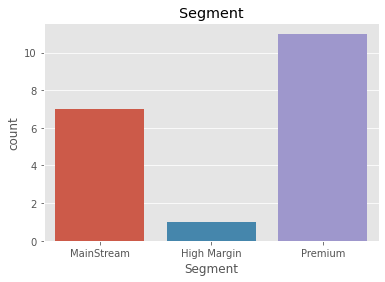

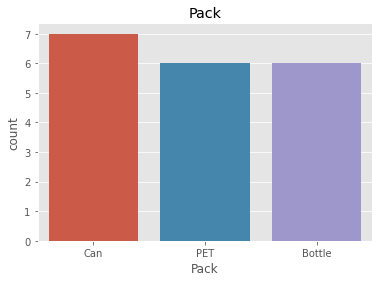

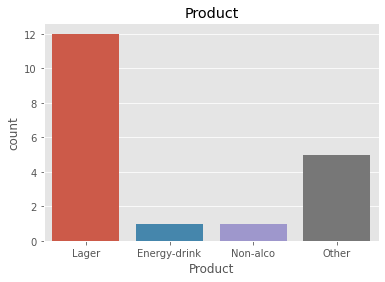

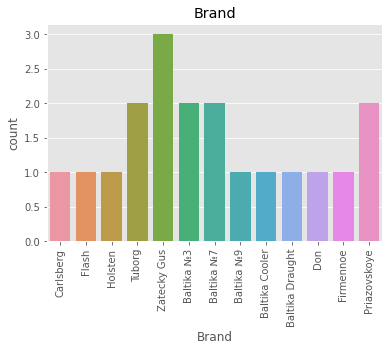

In [7]:
plot_feature_summary(model, 'Segment')
plot_feature_summary(model, 'Pack')
plot_feature_summary(model, 'Product')
plot_feature_summary(model, 'Brand', rot=90)


Let's have a look on the sales figure :

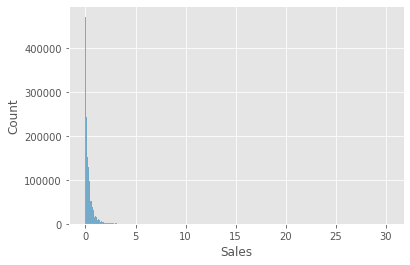

In [8]:
sns.histplot(data=model.train_data, x="Sales", binwidth=0.1)
plt.show()

It seems that there is some outliers : let's remove the data over 3 to have a better view.

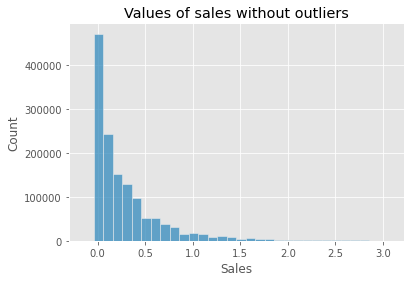

In [9]:
data_clean = model.train_data[model.train_data.Sales < 3]
sns.histplot(data=data_clean, x="Sales", binwidth=0.1)
plt.title("Values of sales without outliers")

plt.show()

<h3>Analysis of the outliers</h3>

Let's have a look at these outliers :

In [10]:
outliers = model.train_data[model.train_data.Sales > 3]
print(outliers.sort_values('Sales', ascending=False))

              Date  ts_id  isPromo   Sales
95757   2015-08-04   1333      1.0  30.200
1303372 2017-05-04    571      1.0  22.410
1302201 2017-05-03   1319      1.0  18.900
1303449 2017-05-04    648      1.0  18.540
98022   2015-08-05   1707      1.0  18.100
...            ...    ...      ...     ...
949743  2016-10-29    559      2.0   3.010
1160895 2017-02-17   1866      1.0   3.008
1155291 2017-02-14   1954      1.0   3.008
1159684 2017-02-17    599      1.0   3.008
1165496 2017-02-20    743      1.0   3.008

[6213 rows x 4 columns]


So we have 6213 outliers out of 1.3 million. Let's dive in the data to understand them better. We start by plotting their dates to see if there is a correlation :

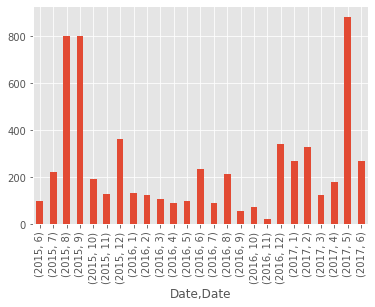

In [11]:
outliers["Date"] = outliers["Date"].astype("datetime64")
outliers["Sales"].groupby([outliers["Date"].dt.year, outliers["Date"].dt.month]).count().plot(kind="bar")
plt.show()

We can see that the distribution of outliers is kind of homogenous, except for August-September 2015 and for May 2017. Now let's have a look in which stores they occurs.

In [12]:
# see for each store, the proportion of outliers

#First, we aggregate the Sales by store
merged_total = pd.merge(model.train_data, model.stores, on='ts_id', how='inner')
total_sales_by_shop = merged_total.groupby("Store")['Sales'].count()

#then we aggregate the outliers by Stores
merged_outliers = pd.merge(outliers, model.stores, on='ts_id', how='inner')
total_outliers_by_shop = merged_outliers.groupby('Store')['Sales'].count()

#We merge both, and we replace the NaN by 0 (means no outliers in the df)
merged_for_comparison = pd.merge(total_sales_by_shop, total_outliers_by_shop, on='Store', how='outer')
if merged_for_comparison['Sales_y'].isnull().values.any():
    merged_for_comparison['Sales_y'] = merged_for_comparison['Sales_y'].fillna(0)
    
merged_for_comparison['%outliers'] = merged_for_comparison['Sales_y'] / merged_for_comparison['Sales_x'] * 100

#Let's see if a store has 5% or more of outliers
print(merged_for_comparison[merged_for_comparison['%outliers'] > 5])


Empty DataFrame
Columns: [Sales_x, Sales_y, %outliers]
Index: []


No store has more than 5% of the outliers. We can't do anything with it.

<h3>Correlations between features</h3>

Let's plot the repartition of the different types of products, and cross it with another features to see if there's something interesting :

In [13]:
def plot_hist_sku(model, feature, hue=None):
    """Plot the histogram representing the distribution of sku across the features [Segment, Pack, Product], and cross it with another feature as color"""
    if feature not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect feature name. Should be one of these : "Segment", "Pack", "Product".""")
    if hue not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect hue name. Should be one of these : "Segment", "Pack", "Product".""")
    sns.histplot(data=model.features, y=feature, hue=hue, palette=sns.color_palette("tab10", len(model.features[hue].unique())), multiple="stack")
    plt.title("Types of " + feature)
    plt.show()

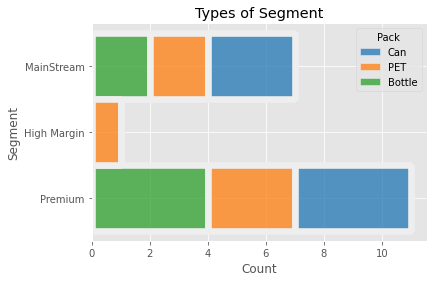

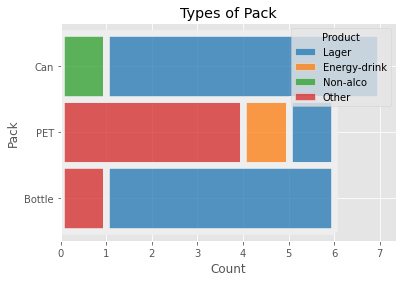

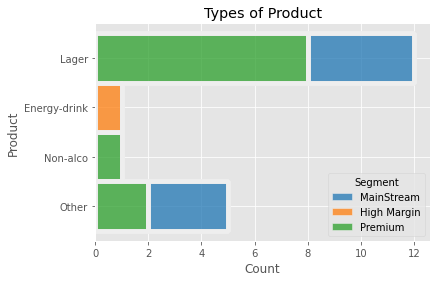

In [14]:
plot_hist_sku(model, "Segment", hue="Pack")
plot_hist_sku(model, "Pack", hue="Product")
plot_hist_sku(model, "Product", hue="Segment")
plt.show()

We can see that all the High Margin are PET, and that the high-margin are actually just the energy drinks. We can as a consequence treat these separately from the beers.

<h2>Analysis of the Energy Drink</h2>

Energy Drinks seems to be relatively independent from beers, let's dive deeper in the analysis for this product.

First, how many models are sold ?

In [15]:
energy_drinks_features = model.features[model.features.Product == 'Energy-drink']
print(energy_drinks_features)

                        SKU      Segment Pack       Product  Brand  Volume
1  _Flash Up Energy PET 0,5  High Margin  PET  Energy-drink  Flash     0.5


There's only one type of energy drinks. Great, and in how many stores is it sold ?

In [16]:
stores_with_energy_drinks = model.stores[model.stores.SKU == '_Flash Up Energy PET 0,5']
print(f"Stores with Energy Drinks on sale : {len(stores_with_energy_drinks)} / {len(list(model.stores['Store'].value_counts()))}")    #stores are already uniques in this dataframe

Stores with Energy Drinks on sale : 51 / 267


Let's check whether these stores also sell alcohol

In [17]:
# Print a boolean showing if at least one of the stores don't sell alcohol
print(0 in pd.merge(stores_with_energy_drinks['Store'], model.stores, on='Store', how='left').groupby('Store').count()['SKU'])

False


Yes, they do.

<h3>Analysis of seasonality</h3>

It seems reasonable to suppose that the consumption of beers is correlated to seasons : people tend to drink more beer on summer than in winter. The range of date covered by the training data goes from June to June so there will be no problem of one month more represented than others. There also must be a pattern with the day of week : more sales on week-ends.
Let's check if it's the case :

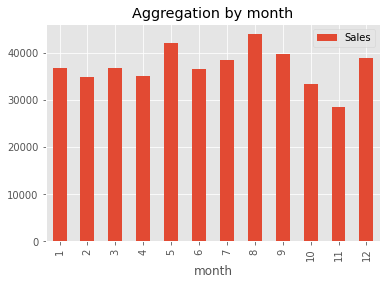

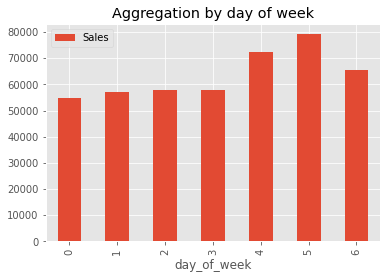

In [18]:
def generate_features_date(df):
    # Time features
    df['day_of_month'] = df['Date'].dt.day
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['week'] = df['Date'].dt.week
    return df

#Let's aggregate sales by months and plot it
generate_features_date(model.train_data)[['month', 'Sales']].groupby('month').sum().plot(kind="bar", title="Aggregation by month")

#Let's aggregate by day of the week
generate_features_date(model.train_data)[['day_of_week', 'Sales']].groupby('day_of_week').sum().plot(kind="bar", title="Aggregation by day of week")

plt.show()

The seasonality by month is surprisingly not relevant. On the other hand, the seasonality by day is definitively a thing : people buy beers on friday and saturday nights !

<h3>Features correlations</h3>

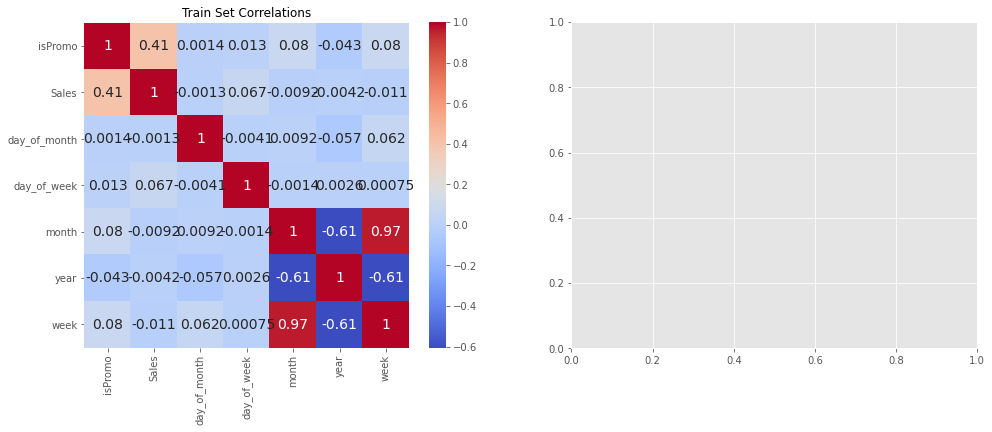

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

df = generate_features_date(model.train_data).drop(['ts_id'], axis=1)

#print(df.columns)


sns.heatmap(df.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
#sns.heatmap(df.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

#for i in range(2):    
for i in range(1):
    axs[i].tick_params(axis='x', labelsize=10)
    axs[i].tick_params(axis='y', labelsize=10)
    
axs[0].set_title('Train Set Correlations', size=12)
#axs[1].set_title('Test Set Correlations', size=12)

plt.show()

TODO

<h2>Feature engineering</h2>

In [2]:
# This is a core part of the transition from a time-series prediction to a regression problem.
# The main idea is to featurize time in a way that it will keep the important information about the date.

def generate_features(df, sku_features, id_map):
        
    # Add metadata
    df = pd.merge(df, id_map, how='left', on='ts_id')
    df = pd.merge(df, sku_features, how='left', on='SKU')

    # Time features
    df['day_of_month'] = df['Date'].dt.day
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['week'] = df['Date'].dt.week
    
    
    return df

We remove the outliers :

In [ ]:
train = train[train['Sales'] < 3]

In [ ]:
# Generate 2 dataframes
train_with_features = generate_features(train, sku_features, id_map)
test_with_features = generate_features(test, sku_features, id_map)

In [ ]:
# Last manipulation of dataframes, to make XGBoost work
'''train_encoded = pd.get_dummies(train_with_features, columns = ['isPromo',
                                                               'Store',
                                                               'Segment',
                                                               'Pack',
                                                               'Product',
                                                               'Brand',
                                                               'Volume',
                                                               'day_of_month',
                                                               'day_of_week',
                                                               'month',
                                                               'year',
                                                               'week'])'''
##
train_encoded = pd.get_dummies(train_with_features, columns = ['isPromo',
                                                               'Segment',
                                                               'Pack',
                                                               'Product'])


# Modify test dataset
test_encoded = pd.get_dummies(test_with_features, columns = ['isPromo',
                                                               'Segment',
                                                               'Pack',
                                                               'Product'])

In [ ]:
#Delete columns from the encoded dataset: Some of these should go back in
del(train_encoded['SKU'], train_encoded['Store'], train_encoded['Brand'], train_encoded['Volume'],train_encoded['day_of_month'])
del(test_encoded['SKU'], test_encoded['Store'], test_encoded['Brand'], test_encoded['Volume'],test_encoded['day_of_month'])

In [ ]:
train_y = train_encoded['Sales']
train_x = train_encoded
del(train_x['Sales'], train_x['Date'])
test = test_encoded
del(test['Date'], test['id']) 

<h2>Design and tuning of the model</h2>

We will use a stacked model, by adding a XGBoost and a Catboost to generate two new features, then use a LGBM as meta-model.

To tune the hyperparameters of the boosters, we use a minimization with optuna : 

In [6]:
import optuna
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [ ]:


def objective_xgb(trial):
    param = {
        #'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)

    assert train_x.shape[0] == train_y.shape[0]

    ## We use 80% of the train set to predict the last 20%
    test_data = train_x[int(0.8 * train_x.shape[0]):]
    test_sales = train_y[int(0.8 * train_y.shape[0]) : ]
    train_data = train_x.drop(list(range(int(0.8 * train_x.shape[0]), train_x.shape[0])))
    train_sales = train_y.drop(list(range(int(0.8 * train_y.shape[0]), train_y.shape[0])))

    ##
    
    model.fit(train_data,train_sales,eval_set=[(test_data,test_sales)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_data)
    
    rmse = mean_squared_error(test_sales, preds,squared=False)
    
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize_xgb(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


With these optimal parameters we can initiate a good model :

In [ ]:
#xgboost optimized by optuna
params = {'lambda': 0.0012178231079520354, 'alpha': 0.0028869163037390107, 'colsample_bytree': 0.7, 'subsample':
 0.7, 'learning_rate': 0.012, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 151}

model = XGBRegressor(**params)


We do the same with catboost :

In [ ]:
def objective_cat(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
    }
    model = CatBoostRegressor(**params)

    assert train_x.shape[0] == train_y.shape[0]

    ## We use 80% of the train set to predict the last 20%
    test_data = train_x[int(0.8 * train_x.shape[0]):]
    test_sales = train_y[int(0.8 * train_y.shape[0]) : ]
    train_data = train_x.drop(list(range(int(0.8 * train_x.shape[0]), train_x.shape[0])))
    train_sales = train_y.drop(list(range(int(0.8 * train_y.shape[0]), train_y.shape[0])))

    ##
    
    model.fit(train_data,train_sales,eval_set=[(test_data,test_sales)],early_stopping_rounds=100,verbose=False)
    
    preds = model.predict(test_data)
    
    rmse = mean_squared_error(test_sales, preds,squared=False)
    
    return rmse


study = optuna.create_study(direction='minimize')
study.optimize_cat(objective, n_trials=20)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
With these optimal parameters we can initiate a good catboost model :

In [ ]:
from catboost import CatBoost


#CatBoost optimized with optuna
cat_booster = CatBoost(params={'iterations': 17515, 'od_wait': 972, 'learning_rate': 0.2554191004881994, 'reg_lambda': 73.42845457676312, 'subsample': 0.24282750184774626, 'random_strength': 15.657259639761643, 'depth': 10, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 9})

from catboost import CatBoost


#CatBoost optimized with optuna
cat_booster = CatBoost(params={'iterations': 17515, 'od_wait': 972, 'learning_rate': 0.2554191004881994, 'reg_lambda': 73.42845457676312, 'subsample': 0.24282750184774626, 'random_strength': 15.657259639761643, 'depth': 10, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 9})



<h2>Generation of the stacked feature</h2>

We use a "sliding k-folds" strategy : we cut the train data in 5 slices, and we train a model with each. Then we predict the test sales by averaging the predictions of all models on the test data.

Something wrong here, I'll fix it later

In [ ]:
def sliding_feature_stacking(data, sales, test, booster, num_samples=5):
    sales_predicted = []
    prop_train_test = 1 / num_samples
    
    prediction_for_test_set = [[] for _ in range(num_samples)]
    
    for i in range(num_samples):
        test_data = data[int(i * data.shape[0] * prop_train_test) : int((i + 1) * data.shape[0] * prop_train_test)]
        test_sales = sales[int(i * data.shape[0] * prop_train_test) : int((i + 1) * data.shape[0] * prop_train_test)]
        train_data = data.drop(list(range(int(i * data.shape[0] * prop_train_test), int((i + 1) * data.shape[0] * prop_train_test))))
        train_sales = sales.drop(list(range(int(i * data.shape[0] * prop_train_test), int((i + 1) * data.shape[0] * prop_train_test))))

        booster.fit(train_data, train_sales)
        prediction = booster.predict(test_data).flatten()
        sales_predicted += list(prediction)
        
        prediction_for_test_set[i] = booster.predict(test).flatten()

        print(f"{i + 1}/{num_samples}")
        
    prediction_for_test_set = np.array(prediction_for_test_set)
    return sales_predicted, np.average(prediction_for_test_set, axis=0)

In [ ]:
predicted_xgbr_feature, predicted_xgbr_for_test = sliding_feature_stacking(train_x, train_y, test, xgbr_booster)
predicted_catboost_feature, predicted_catboost_for_test = sliding_feature_stacking(train_x, train_y, test, cat_booster)


Now we add the predictions of these models as features :

In [ ]:
#We add the predictions as a feature
train_x.insert(len(train_x.columns), "catboost_feature", predicted_catboost_feature)
train_x.insert(len(train_x.columns), "xgbrboost_feature", predicted_xgbr_feature)

train_x.insert(len(train_x.columns), "Sales", train_y)
model.train_features = train_x
model.test_features = test

model.test_features.insert(len(model.test_features.columns), "catboost_feature", predicted_catboost_for_test)
model.test_features.insert(len(model.test_features.columns), "xgbrboost_feature", predicted_xgbr_for_test)

Now we run the meta-model :

In [ ]:
model.run()

<h2>Model Interpretation</h2>
Let's have a look at the partial dependence plots to check whether the model behave properly when a feature change : 

In [3]:
import pdpbox.pdp as pdp

pdp_day_of_week = pdp.pdp_isolate(model.regressor, model.test_features, model.test_features.columns, feature='day_of_week')
pdp.pdp_plot(pdp_day_of_week, 'day_of_week')
plt.ylabel("Change in prediction")


NameError: name 'model' is not defined

More beer is sold on week-ends, not real impact on weekdays. It fits with what we observed during the EDA.

Let's also have a look to the stacked features :

In [ ]:
pdp_catboost = pdp.pdp_isolate(model.regressor, model.test_features, model.test_features.columns, feature='catboost_feature')
pdp.pdp_plot(pdp_catboost, 'catboost_feature')
plt.ylabel("Change in prediction")
plt.show()

pdp_xgbr = pdp.pdp_isolate(model.regressor, model.test_features, model.test_features.columns, feature='xgbrboost_feature')
pdp.pdp_plot(pdp_xgbr, 'xgbrboost_feature')
plt.ylabel("Change in prediction")
plt.show()

The Catboost has a nice outcome for small values of sales, but we observe a saturation for values greater than 0.5. The XGBR seems to have a smoother and more consistent impact on the output.


In [ ]:
lgbm.plot_importance(model.regressor)